In [63]:
import numpy as np
import pandas as pd
import os

import umap.umap_ as umap

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, classification_report

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
models = {
    'lr': LogisticRegression(max_iter=1000, random_state=42),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(max_depth=2, random_state=42),
    'nb': GaussianNB(),
    'svm': svm.SVC(),
    'knc': KNeighborsClassifier(n_neighbors=3),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

param_grids = {
    'lr': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    },
    'dt': {
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'rf': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'svm': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'knc': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'xgb': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

k_folds = KFold(n_splits=5)
model_scores = {}


# With dimentionality reduction

In [ ]:
# Load data

file_path = os.path.join("data","data_umap.csv")

df = pd.read_csv(file_path)  

print(len(df))
df.head()

364


,UMAP1,UMAP2,label
0,14.672715,-12.427366,1
1,14.359391,-12.942661,1
2,14.858253,-11.748547,1
3,14.077615,-12.789752,1
4,14.808619,-12.802444,1


In [ ]:
X = df[['UMAP1','UMAP2']]
Y = df['label']

X_rest, X_test, Y_rest, Y_test = train_test_split(X,Y, test_size=0.15, random_state=42)

encoder = LabelEncoder()
Y_rest = encoder.fit_transform(Y_rest)
Y_test = encoder.transform(Y_test)

In [ ]:

k_folds = KFold(n_splits = 5)

model_scores={}

model_scores = {}

for name, model in models.items():
    if name in param_grids:
        # Use GridSearchCV or RandomizedSearchCV
        search = RandomizedSearchCV(model, param_grids[name], cv=k_folds, scoring='accuracy', n_jobs=-1)
        search.fit(X_rest if name in ['lr', 'svm', 'knc'] else X_rest, Y_rest)
        best_score = search.best_score_
        best_model = search.best_estimator_
        print(f"{name}: Best Score={best_score:.4f}, Best Params={search.best_params_}")
    else:
        scores = cross_val_score(model, X_rest, Y_rest, cv=k_folds, scoring='accuracy')
        best_score = scores.mean()
        best_model = model.fit(X_rest, Y_rest)
        print(f"{name}: Score={best_score:.4f}")
    
    model_scores[name] = (best_score, best_model)

# Select best model
best_model_name = max(model_scores, key=lambda k: model_scores[k][0])
best_model = model_scores[best_model_name][1]
print(f"\nBest model: {best_model_name} with score {model_scores[best_model_name][0]:.4f}")



lr: Best Score=0.8865, Best Params={'solver': 'lbfgs', 'C': 1}
dt: Best Score=0.9060, Best Params={'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
rf: Best Score=0.8994, Best Params={'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
nb: Score=0.8897
svm: Best Score=0.8994, Best Params={'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
knc: Best Score=0.8962, Best Params={'weights': 'uniform', 'n_neighbors': 9}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:17:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


xgb: Best Score=0.8865, Best Params={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Best model: dt with score 0.9060


- RandomizedSearchCV
Best Model: random forest with score 0.9092


- GridSearchCV
Best Model: decision tree with score 0.9092

In [ ]:
best_model = search.best_estimator_  # from GridSearchCV or RandomizedSearchCV

best_model.fit(X_rest, Y_rest)

y_pred = best_model.predict(X_test)

print('Best Model ', best_model_name)
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print(classification_report(Y_test, y_pred))

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:17:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Model  dt
Test Accuracy: 0.8909
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.92      0.69      0.79        16
           2       0.82      0.93      0.88        15
           3       1.00      1.00      1.00        15

    accuracy                           0.89        55
   macro avg       0.89      0.91      0.89        55
weighted avg       0.90      0.89      0.89        55



- feature importance

In [ ]:
result = permutation_importance(best_model, X_test, Y_test, n_repeats=10, random_state=42)
print(result.importances_mean)


[0.55272727 0.23636364]


# Without dimentionality reduction

In [ ]:
# Load data

file_path = os.path.join("data","processed_data.csv")

df = pd.read_csv(file_path)

X=df.drop(columns='Class')
Y=df['Class']

In [ ]:
# dropping columns that acused less permutation importance 

#X=df.drop(columns='')

In [52]:
X_rest, X_test, Y_rest, Y_test = train_test_split(X,Y, test_size=0.15, random_state=42)

encoder = LabelEncoder()
Y_rest = encoder.fit_transform(Y_rest)
Y_test = encoder.transform(Y_test)

k_folds = KFold(n_splits = 5)

model_scores={}

model_scores = {}

for name, model in models.items():
    if name in param_grids:
        # Use GridSearchCV or RandomizedSearchCV
        search = RandomizedSearchCV(model, param_grids[name], cv=k_folds, scoring='accuracy', n_jobs=-1)
        search.fit(X_rest if name in ['lr', 'svm', 'knc'] else X_rest, Y_rest)
        best_score = search.best_score_
        best_model = search.best_estimator_
        print(f"{name}: Best Score={best_score:.4f}, Best Params={search.best_params_}")
    else:
        scores = cross_val_score(model, X_rest, Y_rest, cv=k_folds, scoring='accuracy')
        best_score = scores.mean()
        best_model = model.fit(X_rest, Y_rest)
        print(f"{name}: Score={best_score:.4f}")
    
    model_scores[name] = (best_score, best_model)

# Select best model
best_model_name = max(model_scores, key=lambda k: model_scores[k][0])
best_model = model_scores[best_model_name][1]
print(f"\nBest model: {best_model_name} with score {model_scores[best_model_name][0]:.4f}")



c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


lr: Best Score=0.9386, Best Params={'solver': 'liblinear', 'C': 100}
dt: Best Score=0.9903, Best Params={'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
rf: Best Score=0.9903, Best Params={'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
nb: Score=0.8832
svm: Best Score=0.9612, Best Params={'kernel': 'linear', 'gamma': 'auto', 'C': 100}
knc: Best Score=0.9028, Best Params={'weights': 'uniform', 'n_neighbors': 9}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


xgb: Best Score=0.9967, Best Params={'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Best model: xgb with score 0.9967


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:21:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [53]:
best_model = search.best_estimator_  # from GridSearchCV or RandomizedSearchCV

best_model.fit(X_rest, Y_rest)

y_pred = best_model.predict(X_test)

print('Best Model ', best_model_name)
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print(classification_report(Y_test, y_pred))

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:21:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Model  xgb
Test Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



- Feature Importance

In [54]:
result = permutation_importance(best_model, X_test, Y_test, n_repeats=10, random_state=42)
print(result.importances_mean)
importances=result.importances_mean
df.columns


[0.         0.         0.         0.01090909 0.         0.
 0.         0.         0.         0.70181818 0.         0.00181818
 0.         0.        ]


Index(['Feature', 'Importance'], dtype='object')

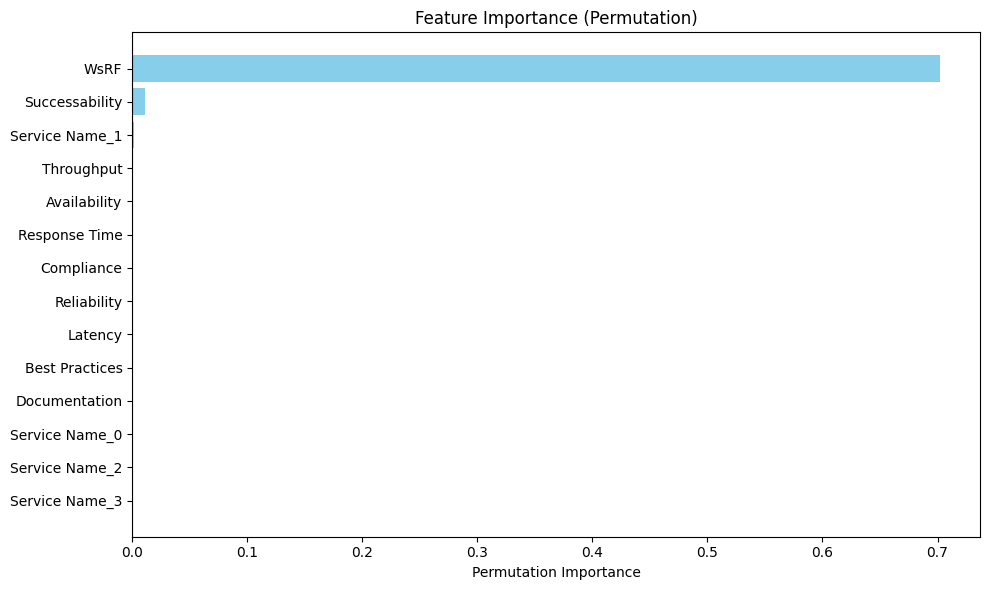

In [55]:
# Feature names and importance values
features = X.columns

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df_sorted = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

# Classify without WsRF

In [56]:
X_filtered=X.drop(columns='WsRF')

In [57]:
X_rest, X_test, Y_rest, Y_test = train_test_split(X_filtered,Y, test_size=0.15, random_state=42)

encoder = LabelEncoder()
Y_rest = encoder.fit_transform(Y_rest)
Y_test = encoder.transform(Y_test)

k_folds = KFold(n_splits = 5)

model_scores={}

model_scores = {}

for name, model in models.items():
    if name in param_grids:
        # Use GridSearchCV or RandomizedSearchCV
        search = RandomizedSearchCV(model, param_grids[name], cv=k_folds, scoring='accuracy', n_jobs=-1)
        search.fit(X_rest if name in ['lr', 'svm', 'knc'] else X_rest, Y_rest)
        best_score = search.best_score_
        best_model = search.best_estimator_
        print(f"{name}: Best Score={best_score:.4f}, Best Params={search.best_params_}")
    else:
        scores = cross_val_score(model, X_rest, Y_rest, cv=k_folds, scoring='accuracy')
        best_score = scores.mean()
        best_model = model.fit(X_rest, Y_rest)
        print(f"{name}: Score={best_score:.4f}")
    
    model_scores[name] = (best_score, best_model)

# Select best model
best_model_name = max(model_scores, key=lambda k: model_scores[k][0])
best_model = model_scores[best_model_name][1]
print(f"\nBest model: {best_model_name} with score {model_scores[best_model_name][0]:.4f}")



c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


lr: Best Score=0.9191, Best Params={'solver': 'liblinear', 'C': 100}
dt: Best Score=0.8836, Best Params={'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}
rf: Best Score=0.9191, Best Params={'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
nb: Score=0.8767
svm: Best Score=0.9190, Best Params={'kernel': 'linear', 'gamma': 'scale', 'C': 1}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


knc: Best Score=0.8996, Best Params={'weights': 'uniform', 'n_neighbors': 9}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:24:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


xgb: Best Score=0.9191, Best Params={'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Best model: lr with score 0.9191


In [58]:
best_model = search.best_estimator_  # from GridSearchCV or RandomizedSearchCV

best_model.fit(X_rest, Y_rest)

y_pred = best_model.predict(X_test)

print('Best Model ', best_model_name)
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print(classification_report(Y_test, y_pred))

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:25:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Model  lr
Test Accuracy: 0.8727
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.75      0.94      0.83        16
           2       0.88      0.93      0.90        15
           3       1.00      0.93      0.97        15

    accuracy                           0.87        55
   macro avg       0.91      0.84      0.85        55
weighted avg       0.89      0.87      0.87        55



In [59]:
result = permutation_importance(best_model, X_test, Y_test, n_repeats=10, random_state=42)
print(result.importances_mean)
importances=result.importances_mean
df.columns


[0.01454545 0.         0.         0.01272727 0.06181818 0.
 0.         0.         0.00545455 0.18545455 0.24181818 0.06909091
 0.03818182]


Index(['Feature', 'Importance'], dtype='object')

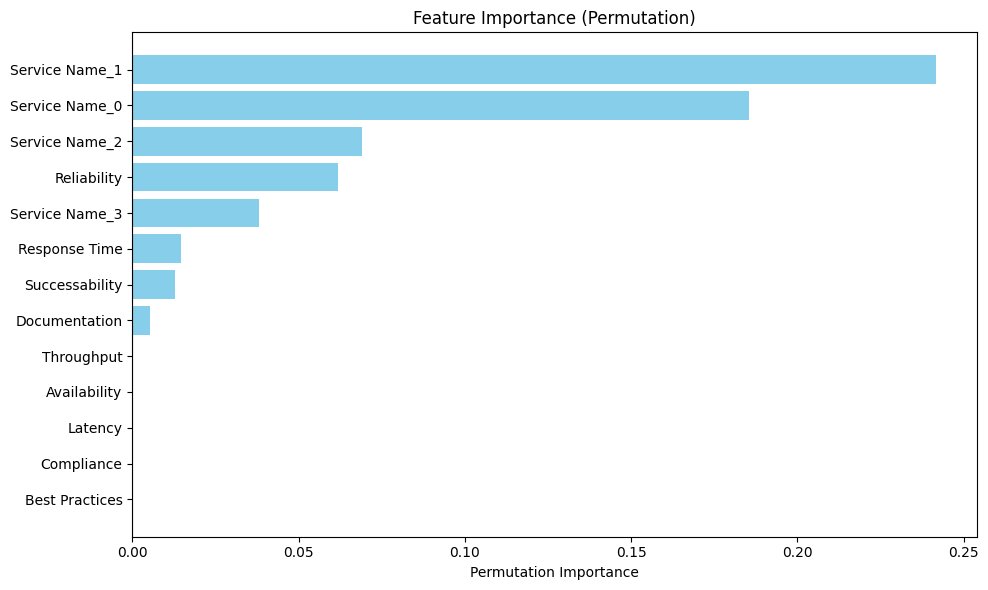

In [61]:
# Feature names and importance values
features = X_filtered.columns

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df_sorted = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

# Dimentionality Reduction after WsRF removal

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


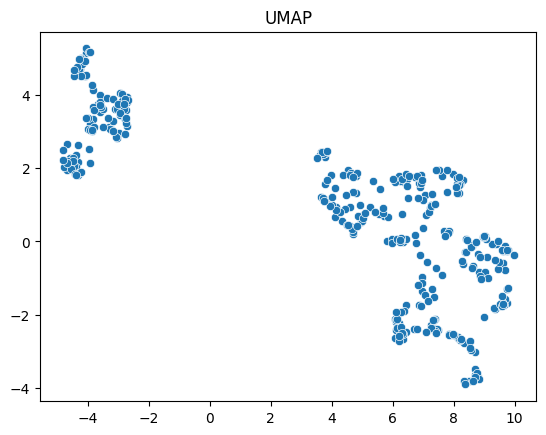

In [64]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_filtered)

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1])
plt.title("UMAP")
plt.show()

In [67]:
X_rest, X_test, Y_rest, Y_test = train_test_split(X_umap,Y, test_size=0.15, random_state=42)

encoder = LabelEncoder()
Y_rest = encoder.fit_transform(Y_rest)
Y_test = encoder.transform(Y_test)

k_folds = KFold(n_splits = 5)

model_scores={}

model_scores = {}

for name, model in models.items():
    if name in param_grids:
        # Use GridSearchCV or RandomizedSearchCV
        search = RandomizedSearchCV(model, param_grids[name], cv=k_folds, scoring='accuracy', n_jobs=-1)
        search.fit(X_rest if name in ['lr', 'svm', 'knc'] else X_rest, Y_rest)
        best_score = search.best_score_
        best_model = search.best_estimator_
        print(f"{name}: Best Score={best_score:.4f}, Best Params={search.best_params_}")
    else:
        scores = cross_val_score(model, X_rest, Y_rest, cv=k_folds, scoring='accuracy')
        best_score = scores.mean()
        best_model = model.fit(X_rest, Y_rest)
        print(f"{name}: Score={best_score:.4f}")
    
    model_scores[name] = (best_score, best_model)

# Select best model
best_model_name = max(model_scores, key=lambda k: model_scores[k][0])
best_model = model_scores[best_model_name][1]
print(f"\nBest model: {best_model_name} with score {model_scores[best_model_name][0]:.4f}")



lr: Best Score=0.8673, Best Params={'solver': 'lbfgs', 'C': 10}
dt: Best Score=0.8414, Best Params={'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
rf: Best Score=0.8834, Best Params={'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}
nb: Score=0.8867
svm: Best Score=0.8899, Best Params={'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
knc: Best Score=0.8770, Best Params={'weights': 'uniform', 'n_neighbors': 5}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:35:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


xgb: Best Score=0.8737, Best Params={'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

Best model: svm with score 0.8899


In [68]:
best_model = search.best_estimator_  # from GridSearchCV or RandomizedSearchCV

best_model.fit(X_rest, Y_rest)

y_pred = best_model.predict(X_test)

print('Best Model ', best_model_name)
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print(classification_report(Y_test, y_pred))

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:36:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Model  svm
Test Accuracy: 0.8727
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.78      0.88      0.82        16
           2       0.88      0.93      0.90        15
           3       1.00      0.93      0.97        15

    accuracy                           0.87        55
   macro avg       0.88      0.85      0.86        55
weighted avg       0.88      0.87      0.87        55



In [69]:
result = permutation_importance(best_model, X_test, Y_test, n_repeats=10, random_state=42)
print(result.importances_mean)
importances=result.importances_mean
df.columns


[0.46727273 0.28727273]


Index(['Feature', 'Importance'], dtype='object')